Zadaniem jest określenie typów wina na podstawie poniższego zbioru danych:

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html
- Przeprowadź krótką wstępną analizę danych
- Zaproponuj rozwiązanie za pomocą XGBoost
- Stwórz funkcję budującą model (DNN)
- Przeprowadź trening i walidację wyników
- Na podstawie historii treningu przedstaw zmianę funkcji loss
- Sprawdź jak zmiana parametrów i architektury Twojej sieci wpływa na wyniki i przedstaw swoje obserwacje
- Porównaj wyniki modeli (może to być krótki opis)

In [1]:
from sklearn.datasets import load_wine
data = load_wine()
print(data.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

### 1. Wgranie bibliotek

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

### 2. Analiza danych:

In [3]:
data.data.shape

(178, 13)

In [4]:
data.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [5]:
data.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [6]:
data.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [7]:
class_number = len(data.target_names)
print(f"target_names: {data.target_names}\nclassNum: {class_number}")

target_names: ['class_0' 'class_1' 'class_2']
classNum: 3


In [8]:
data.data.dtype

dtype('float64')

In [9]:
x = data.data.astype(np.float32)
y = data.target
classNum = len(data.target_names)

In [10]:
class_values, class_counts = np.unique(y, return_counts=True)
for name, value, count in zip(data.target_names, class_values, class_counts):
    print(f"{name} {value}: {count}")

class_0 0: 59
class_1 1: 71
class_2 2: 48


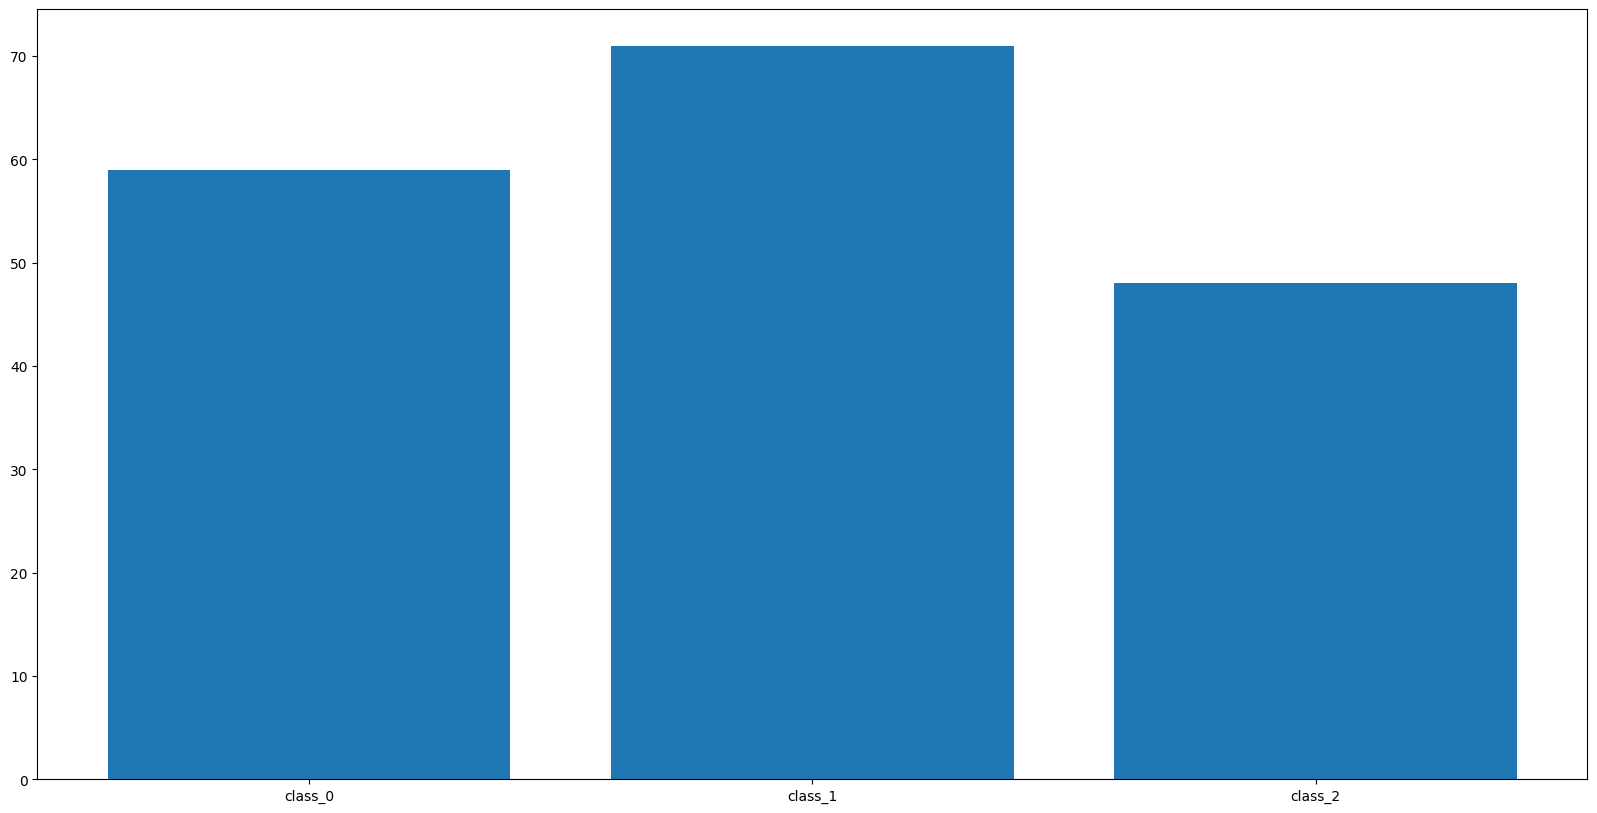

In [11]:
fig = plt.figure(figsize=(20,10))
plt.bar(data.target_names, class_counts)
plt.show()

Klasy są w miare wyrównane

In [12]:
df_x = pd.DataFrame(data=x, columns=data.feature_names)
df_x.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43          15.600000      127.0           2.80   
1    13.20        1.78  2.14          11.200000      100.0           2.65   
2    13.16        2.36  2.67          18.600000      101.0           2.80   
3    14.37        1.95  2.50          16.799999      113.0           3.85   
4    13.24        2.59  2.87          21.000000      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  
0                          3.92   1065.0  
1                          3.40   1050.0  
2                          3.17   1185.0  
3                          3.45   1480.0  
4                          2.93    735.0

In [13]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float32
 1   malic_acid                    178 non-null    float32
 2   ash                           178 non-null    float32
 3   alcalinity_of_ash             178 non-null    float32
 4   magnesium                     178 non-null    float32
 5   total_phenols                 178 non-null    float32
 6   flavanoids                    178 non-null    float32
 7   nonflavanoid_phenols          178 non-null    float32
 8   proanthocyanins               178 non-null    float32
 9   color_intensity               178 non-null    float32
 10  hue                           178 non-null    float32
 11  od280/od315_of_diluted_wines  178 non-null    float32
 12  proline                       178 non-null    float32
dtypes: fl

In [14]:
df_x.describe()

alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000619    2.336349    2.366517          19.494944   99.741570   
std      0.811827    1.117146    0.274344           3.339564   14.282483   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200001   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029269              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.980000    0.340000              0.130000         0.410000   
25%         1.742500    1.205000              0.270000         1.250000   
50%         2.355000    2.135000              0.340000         1.555000   
75%         2.800000    2.875000              0.437500         1.950000   
max         3.880000    5.080000              0.660000         3.580000   

       color_intensity         hue  od280/od315_of_diluted_wines      proline  
count       178.000000  178.000000                    178.000000   178.000000  
mean          5.058090    0.957449                      2.611685   746.893250  
std           2.318286    0.228572                      0.709990   314.907471  
min           1.280000    0.480000                      1.270000   278.000000  
25%           3.220000    0.782500                      1.937500   500.500000  
50%           4.690000    0.965000                      2.780000   673.500000  
75%           6.200000    1.120000                      3.170000   985.000000  
max          13.000000    1.710000                      4.000000  1680.000000

In [15]:
df_x.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

In [16]:
cols=['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline']

In [17]:
for i in cols:
    print(f'Liczba kategorii zmiennej {i}: \n {df_x[i].value_counts()}')

Liczba kategorii zmiennej alcohol: 
 alcohol
12.37    6
13.05    6
12.08    5
12.29    4
12.00    3
        ..
12.45    1
14.34    1
12.36    1
13.69    1
12.96    1
Name: count, Length: 126, dtype: int64
Liczba kategorii zmiennej malic_acid: 
 malic_acid
1.73    7
1.67    4
1.81    4
1.61    3
1.51    3
       ..
1.45    1
1.25    1
1.36    1
1.10    1
3.87    1
Name: count, Length: 133, dtype: int64
Liczba kategorii zmiennej ash: 
 ash
2.30    7
2.28    7
2.70    6
2.32    6
2.36    6
       ..
2.15    1
2.75    1
2.69    1
2.86    1
2.37    1
Name: count, Length: 79, dtype: int64
Liczba kategorii zmiennej alcalinity_of_ash: 
 alcalinity_of_ash
20.000000    15
16.000000    11
21.000000    11
18.000000    10
19.000000     9
             ..
20.799999     1
26.500000     1
23.500000     1
25.500000     1
27.000000     1
Name: count, Length: 63, dtype: int64
Liczba kategorii zmiennej magnesium: 
 magnesium
88.0     13
86.0     11
101.0     9
98.0      9
96.0      8
102.0     7
85.0      

In [18]:
print("Null value counts in each column:")
print(df_x.isna().sum())

Null value counts in each column:
alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


Nie ma zadnych pustych komórek

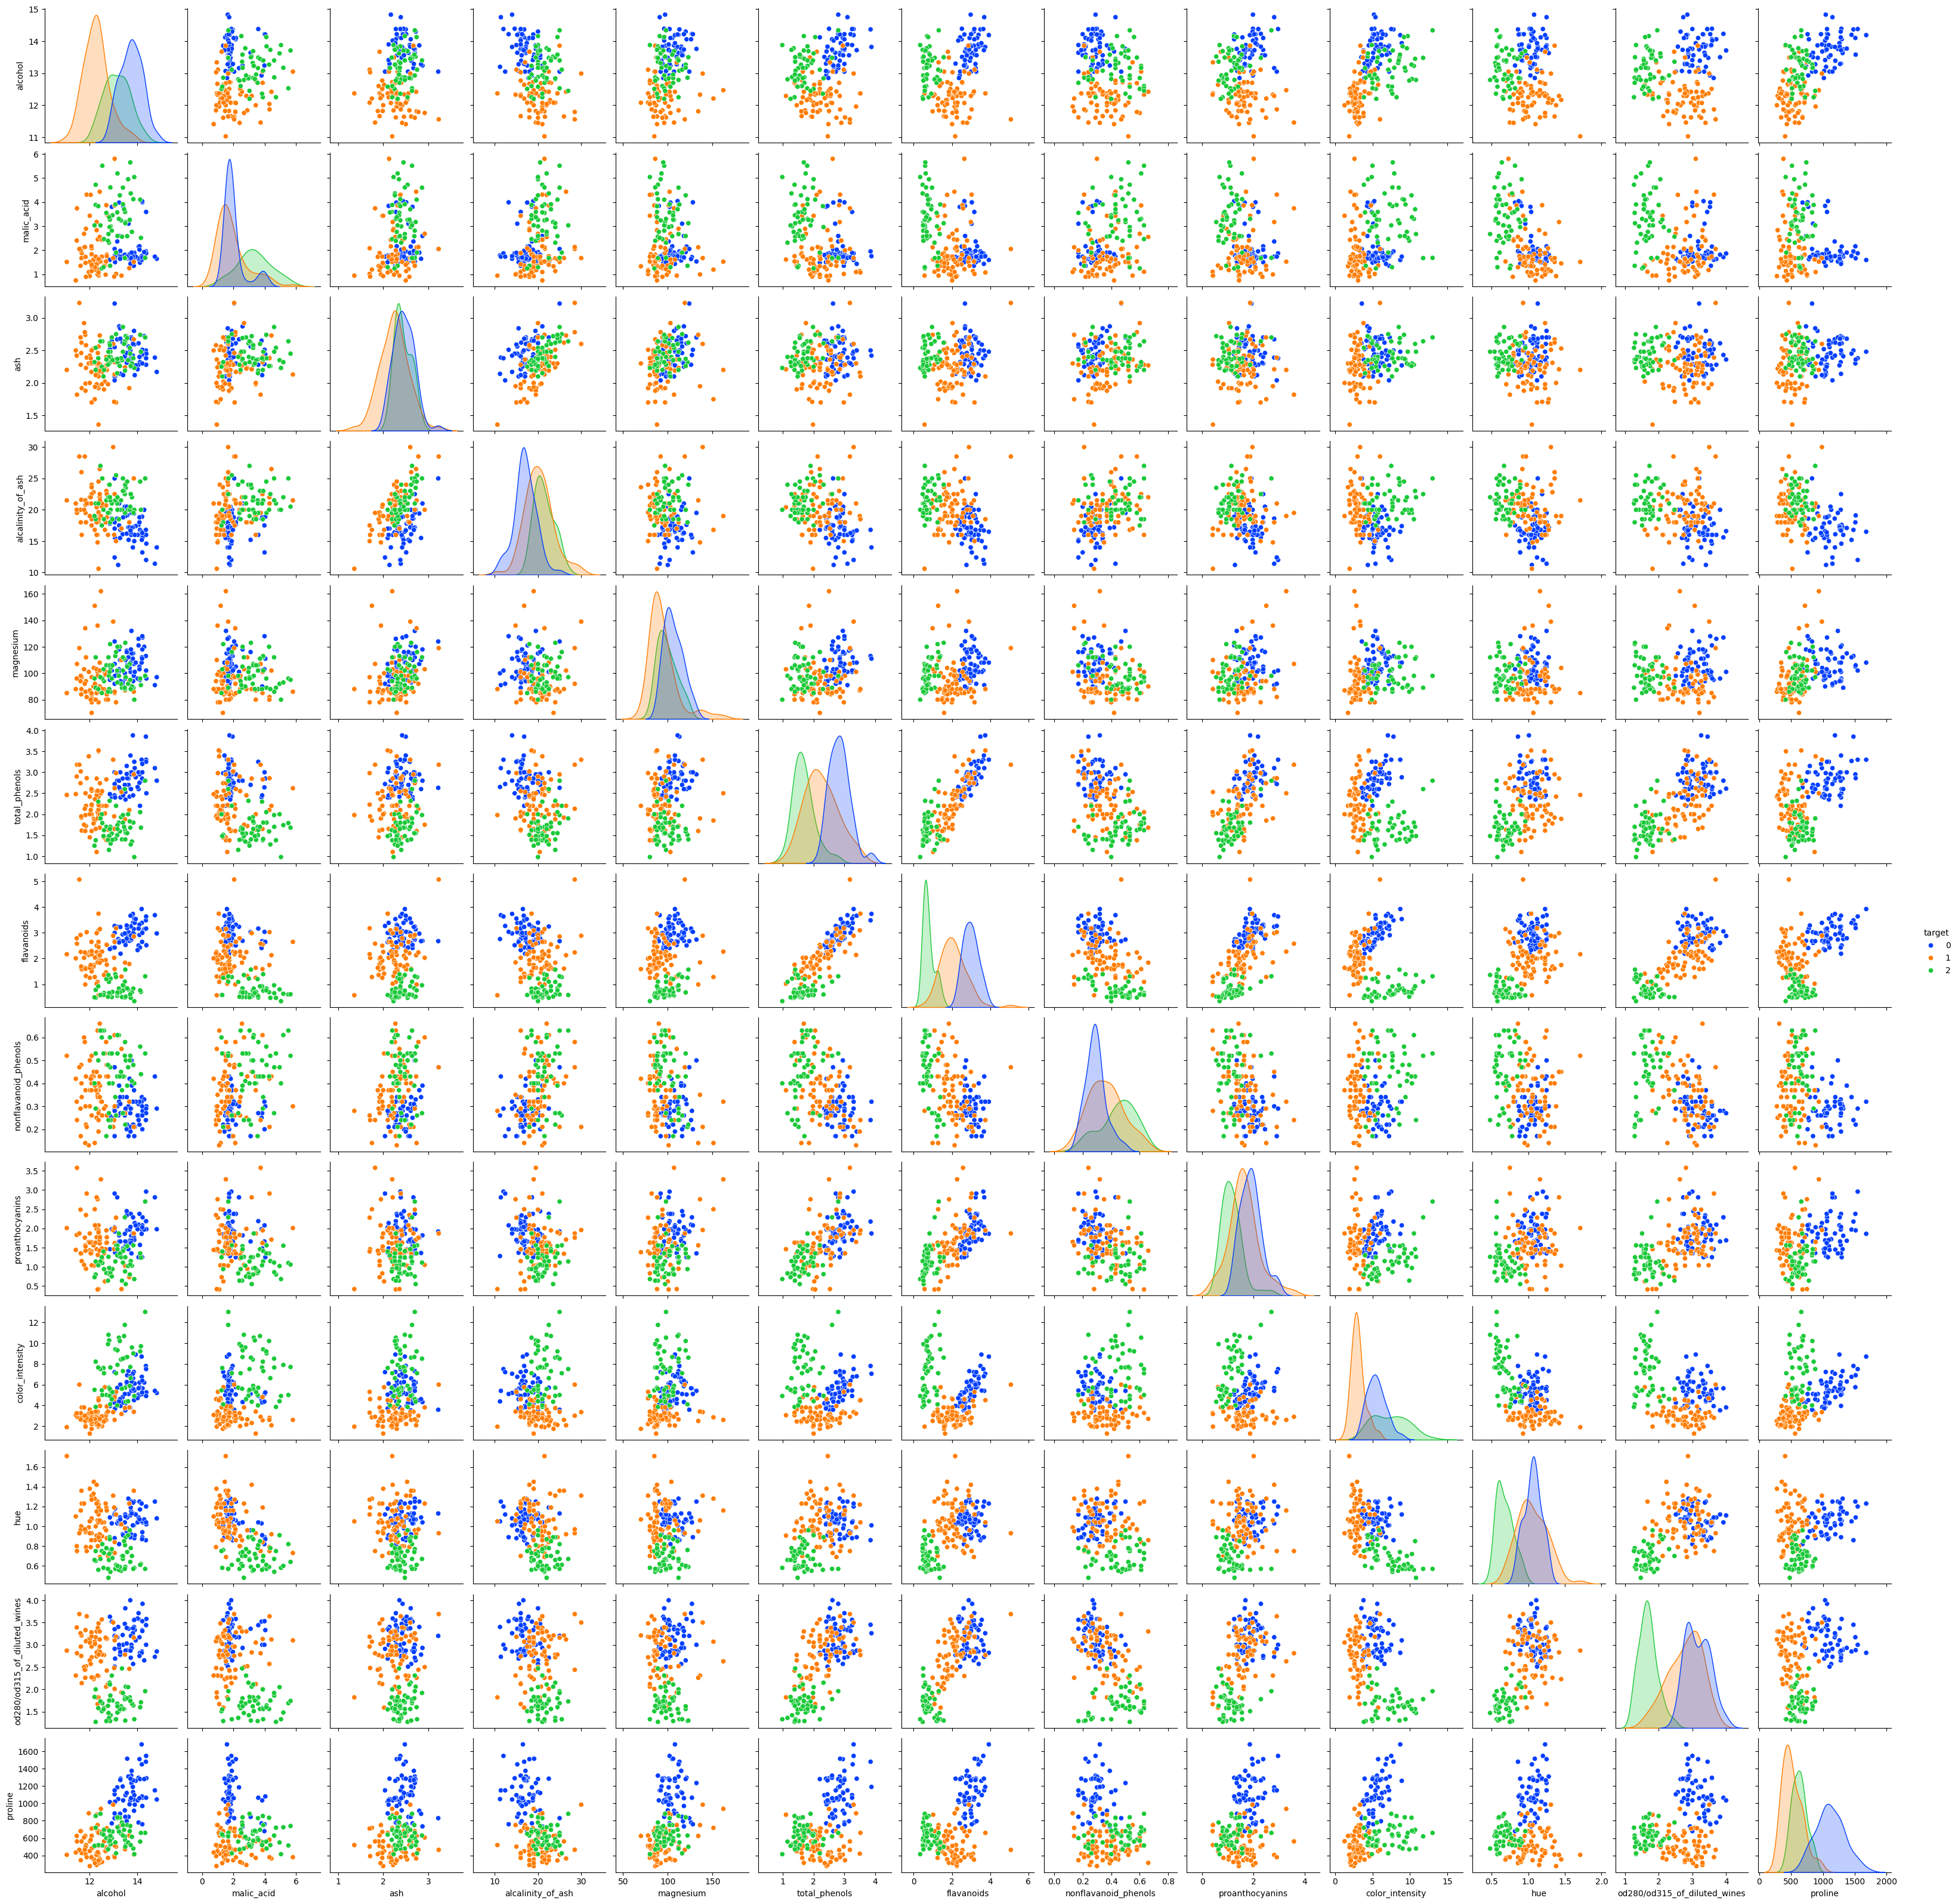

In [19]:
# Tworzenie DataFrame z danych wejściowych do pairplota
df = pd.DataFrame(df_x, columns=cols)
df['target'] = y

sns.pairplot(data = df, hue = 'target', palette='bright' )

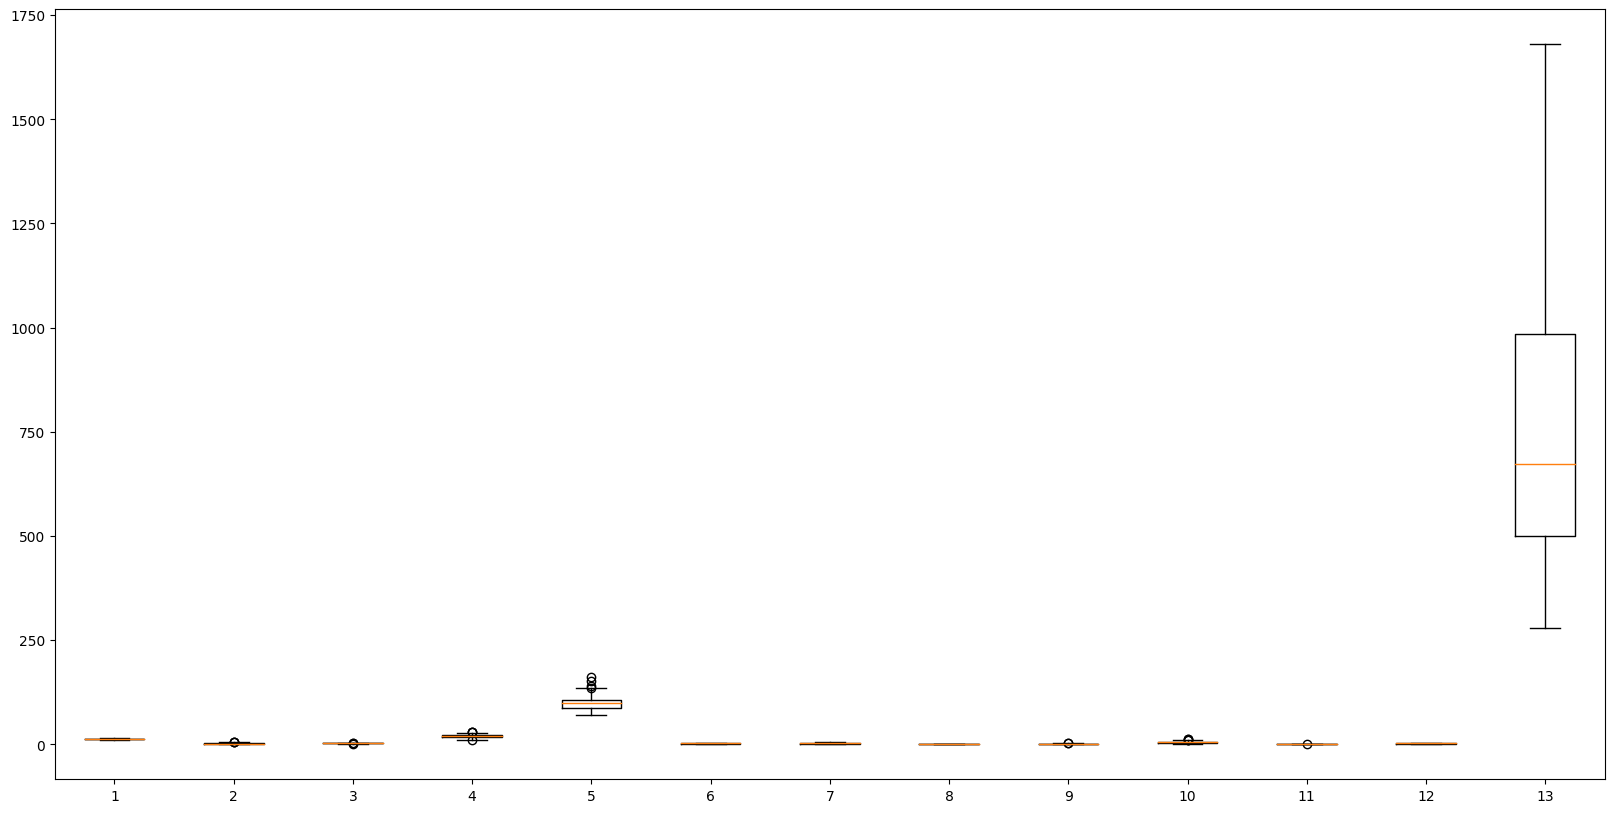

In [20]:
fig = plt.figure(figsize=(20,10))
plt.boxplot(x)
plt.show()

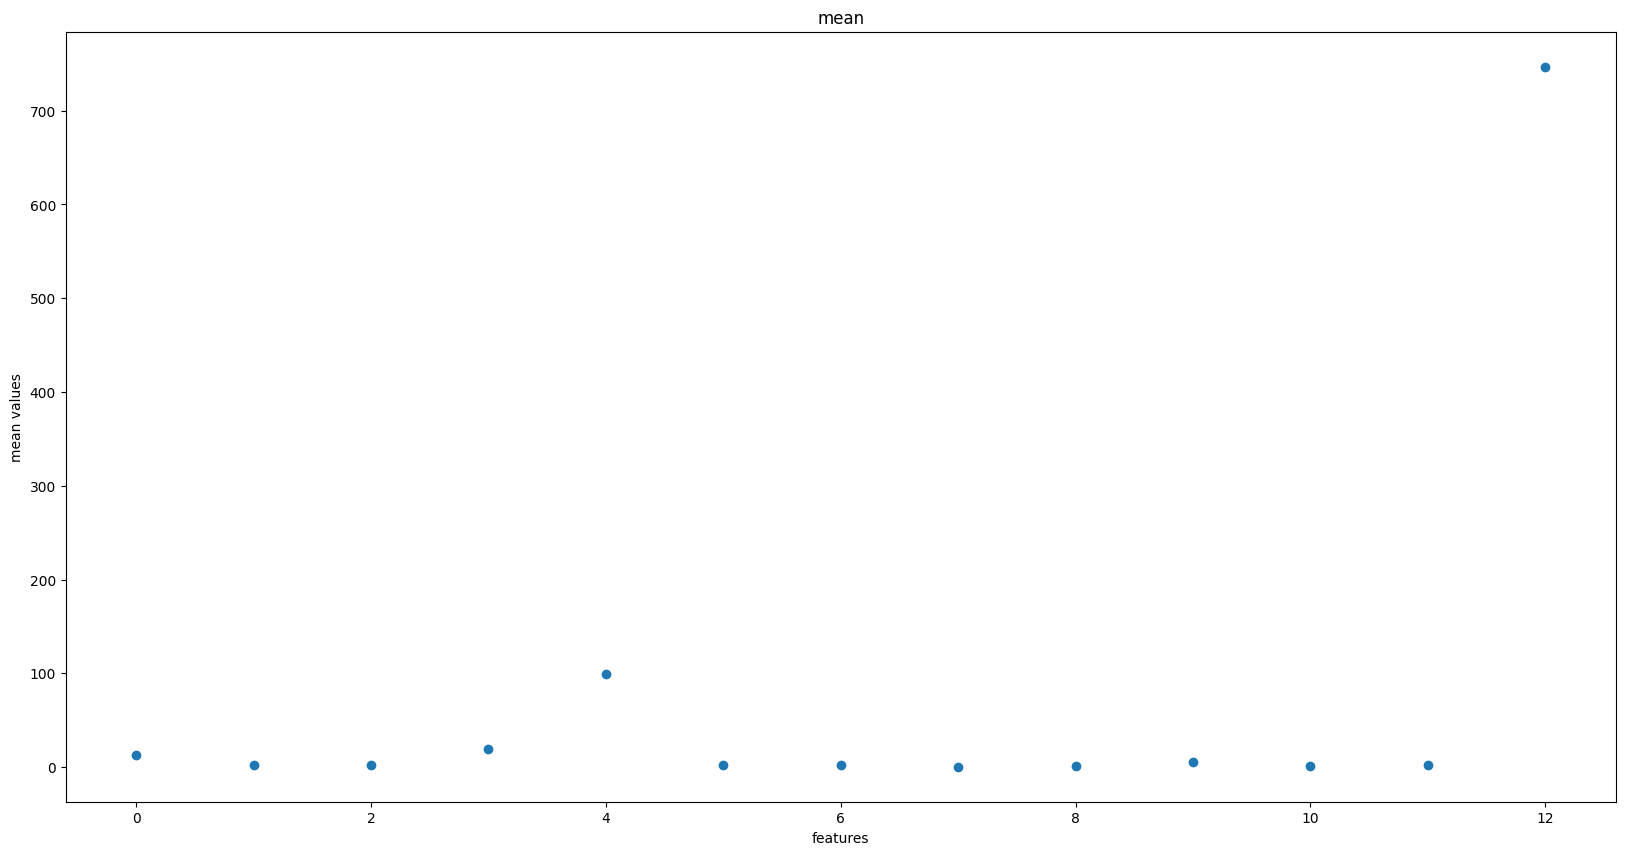

In [21]:
df_metrics = df_x.describe(include="all")
index = 1
name_of_metric = df_metrics.index[index]
fig = plt.figure(figsize=(20,10))
plt.plot(df_metrics.iloc[index].values, marker="o", linestyle="")
plt.xlabel("features")
plt.ylabel(f"{name_of_metric} values")
plt.title(name_of_metric)
plt.show()

Przeskalujmy wyniki zeby byly w jednej skali

In [22]:
x = MinMaxScaler().fit_transform(x)

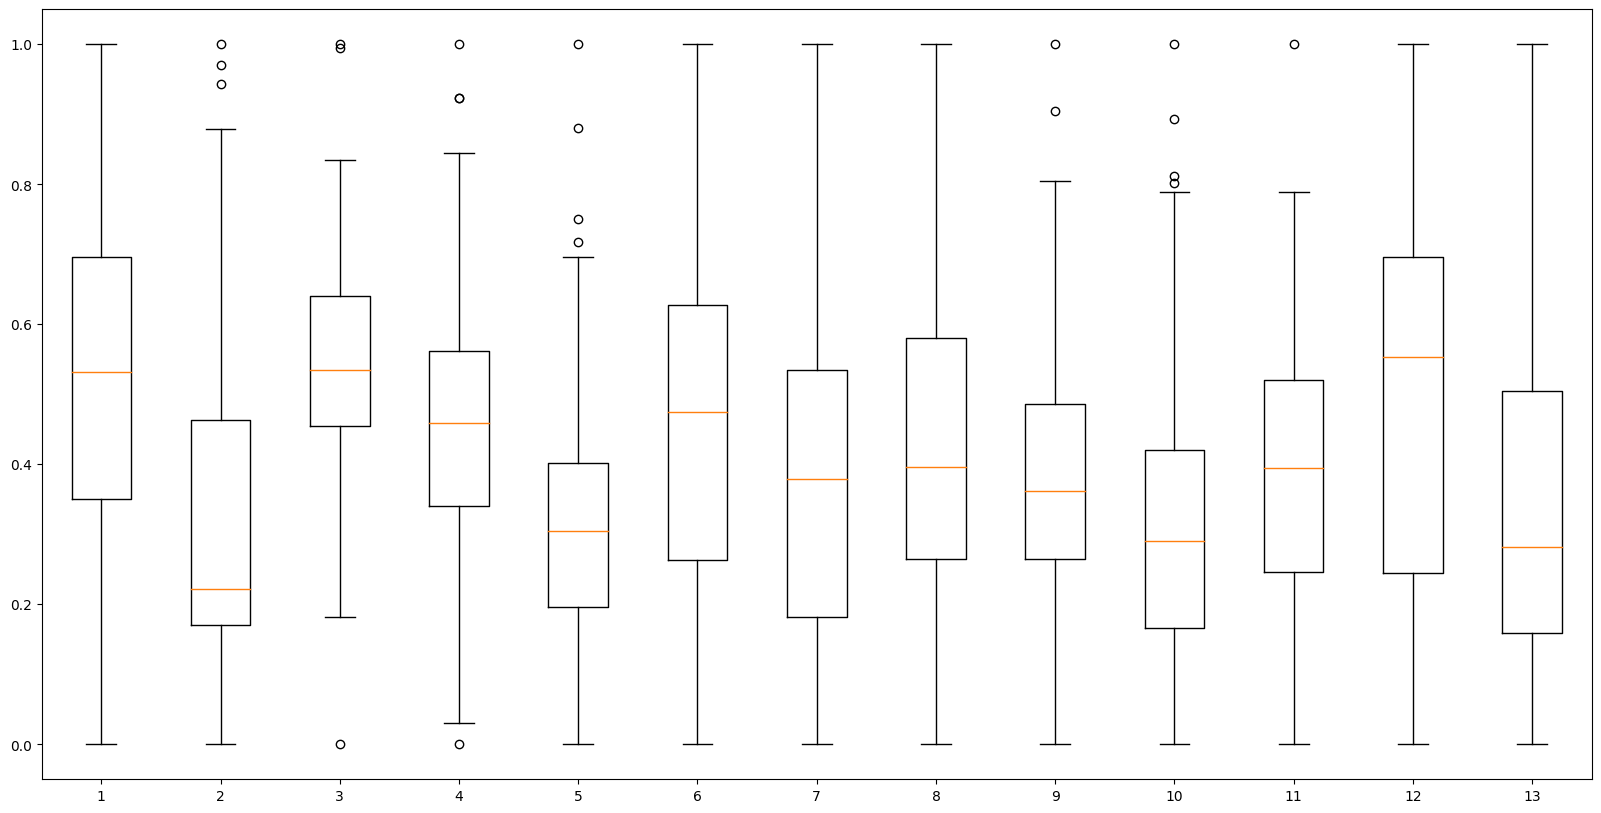

In [23]:
fig = plt.figure(figsize=(20,10))
plt.boxplot(x)
plt.show()

In [24]:
corr = df_x.corr(method = 'spearman', numeric_only=True)

In [25]:
corr.style.background_gradient(vmin=-1, vmax=1, cmap="coolwarm").format(precision=3)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_x, y, test_size=0.2, random_state=23)

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(142, 13)
(36, 13)
(142,)
(36,)


### 3. Model XGBoost

In [28]:
# Utworzenie obiektu DMatrix dla XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definicja parametrów modelu
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 5,
    'max_leaves': 30,
    'n_estimators': 30,
    'learning_rate': 0.1,
    'gamma': 0.1,
    'eval_metric': 'merror'
}

# Trenowanie modelu
num_rounds = 100  # liczba rund (iteracji) treningowych
model = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'eval')], early_stopping_rounds=10)

# Predykcja na zbiorze testowym
y_pred = model.predict(dtest)

# Wyświetlenie wyników
print("Wyniki predykcji:")
print(y_pred)

[0]	eval-merror:0.02778
[1]	eval-merror:0.02778
[2]	eval-merror:0.02778
[3]	eval-merror:0.02778
[4]	eval-merror:0.02778
[5]	eval-merror:0.02778
[6]	eval-merror:0.02778
[7]	eval-merror:0.02778
[8]	eval-merror:0.02778
[9]	eval-merror:0.00000
[10]	eval-merror:0.00000
[11]	eval-merror:0.00000
[12]	eval-merror:0.00000
[13]	eval-merror:0.00000
[14]	eval-merror:0.00000
[15]	eval-merror:0.00000
[16]	eval-merror:0.00000
[17]	eval-merror:0.00000
[18]	eval-merror:0.00000
Wyniki predykcji:
[2. 0. 2. 2. 1. 1. 1. 1. 2. 0. 1. 1. 2. 0. 2. 1. 1. 1. 2. 1. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 2. 1. 2. 0. 0. 2.]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:33:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


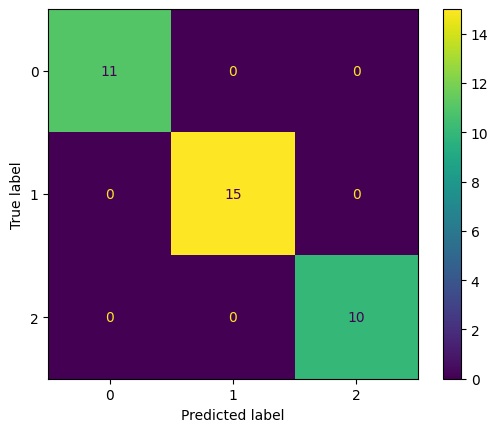

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [30]:
y_pred_test = model.predict(dtest)
y_pred_test = np.round(y_pred_test).astype(int)

y_pred_train = model.predict(dtrain)
y_pred_train = np.round(y_pred_train).astype(int)



accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Dokładność predykcji na zbiorze testowym: {accuracy_test:.2f}")

print("\nRaport klasyfikacji na zbiorze testowym:")
print(classification_report(y_test, y_pred_test))

print("\nMacierz pomyłek na zbiorze testowym:")
print(confusion_matrix(y_test, y_pred_test))



accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"\nDokładność predykcji na zbiorze treningowym: {accuracy_train:.2f}")

print("\nRaport klasyfikacji na zbiorze treningowym:")
print(classification_report(y_train, y_pred_train))

print("\nMacierz pomyłek na zbiorze treningowym:")
print(confusion_matrix(y_train, y_pred_train))

Dokładność predykcji na zbiorze testowym: 1.00

Raport klasyfikacji na zbiorze testowym:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


Macierz pomyłek na zbiorze testowym:
[[11  0  0]
 [ 0 15  0]
 [ 0  0 10]]

Dokładność predykcji na zbiorze treningowym: 1.00

Raport klasyfikacji na zbiorze treningowym:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        38

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00

### 4. SIEĆ NEURONOWA

In [39]:
tf.random.set_seed(42)

In [40]:
# One-hot encoding
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [41]:
model = Sequential()

In [42]:
# Warstwy
model.add(layers.InputLayer(input_shape=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 klasy wyjściowe

In [43]:
# Kompilacja
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                448       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
Total params: 1027 (4.01 KB)
Trainable params: 1027 (4.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# Trenowanie
history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=200, batch_size=32, verbose=1)

Epoch 1/200
5/5 [==============================] - 1s 52ms/step - loss: 42.4980 - accuracy: 0.3380 - val_loss: 34.4242 - val_accuracy: 0.3056
Epoch 2/200
5/5 [==============================] - 0s 10ms/step - loss: 29.4377 - accuracy: 0.3380 - val_loss: 21.5897 - val_accuracy: 0.3056
Epoch 3/200
5/5 [==============================] - 0s 10ms/step - loss: 17.2571 - accuracy: 0.3380 - val_loss: 10.2819 - val_accuracy: 0.3611
Epoch 4/200
5/5 [==============================] - 0s 10ms/step - loss: 8.7474 - accuracy: 0.2746 - val_loss: 4.4965 - val_accuracy: 0.2778
Epoch 5/200
5/5 [==============================] - 0s 10ms/step - loss: 3.0417 - accuracy: 0.2746 - val_loss: 1.8128 - val_accuracy: 0.3889
Epoch 6/200
5/5 [==============================] - 0s 10ms/step - loss: 1.5009 - accuracy: 0.4648 - val_loss: 1.7431 - val_accuracy: 0.3333
Epoch 7/200
5/5 [==============================] - 0s 10ms/step - loss: 1.8761 - accuracy: 0.4296 - val_loss: 1.2209 - val_accuracy: 0.6944
Epoch 8/200
5/

In [45]:
# Ocena modelu
scores = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Accuracy: {scores[1]}")

Accuracy: 1.0


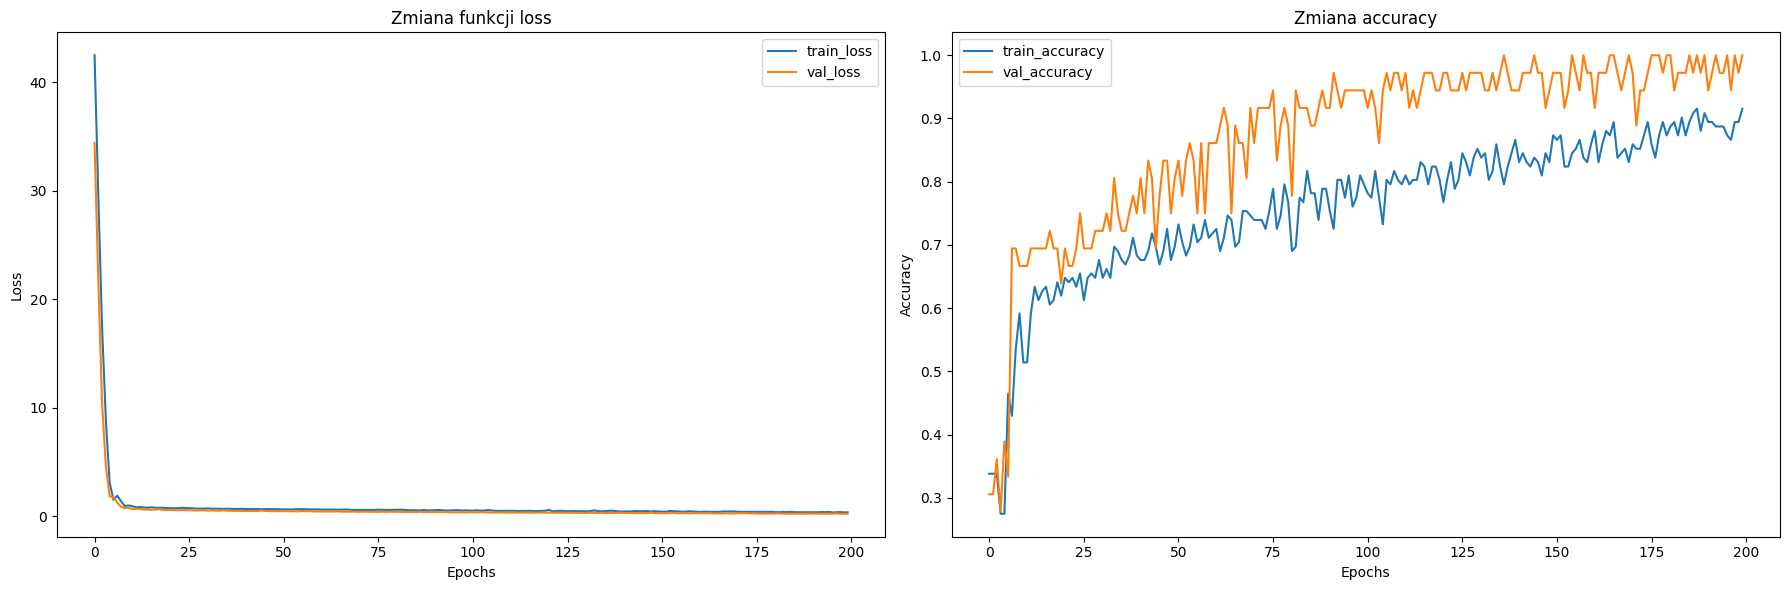

In [46]:
# Wykresy
plt.figure(figsize=(18, 6))

# Wykres funkcji loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Zmiana funkcji loss')
plt.legend()

# Wykres accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Zmiana accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
# Przewidywanie dla zbioru treningowego i testowego
y_train_pred_prob = model.predict(X_train)
y_test_pred_prob = model.predict(X_test)

# Zamienmy prawdopodobienstwo na klasy
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)


print("Classification Report - Train Set")
print(classification_report(y_train, y_train_pred))


print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))

2/2 [==============================] - 0s 3ms/step
Classification Report - Train Set
              precision    recall  f1-score   support

           0       0.95      0.83      0.89        48
           1       0.87      0.96      0.92        56
           2       0.95      0.95      0.95        38

    accuracy                           0.92       142
   macro avg       0.92      0.91      0.92       142
weighted avg       0.92      0.92      0.91       142

Classification Report - Test Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



# 5. PODSUMOWANIE

**XGBoost**

wykonano próbe dla wielu parametrów - zawsze wychodzi accuracy 1.0.

Jednym z wniosków może być, że model jest naprawdę dobrze wytrenowany.

Drugi wniosek, który uważam za bardziej prawdopodobny - model się zbytnio dopasowuje do danych - może to byc spowodawane tym, że nasza baza danych jest bardzo skromna. Zaledwie 178 rekordów.

**Sieć Neuronowa**

Wykonano próby dla wielu paramterów.

Zauważono, że zmiana optimizera na inne sprawiała że przy tej samej ilości epok dokładność modelu spadała znacznie - nawet do 0.45.
Optimizer ADAM - daje najlepszy rezultat.

Przy użyciu metody Early_stopping na 5 epok - model przestawał robić obliczenia juz po 15 epokach. Przy 10 również zatrzymywał się wcześniej z bardzo słabym wynikiem.

Zmiana batch size miała znaczny wpływ na kształt wykresu - przy ustawieniu na 10/16/32 wartości od 0.97 do 1 - ale przy 32 batchach wykres ma znacznie mniejsze "piki".


Ilość epok - wybróbowano 50, 100, 150, 200 - najlepszy rezultat przyniosło 200 epok.

Zmiana random seed na inną wartość już ma spory wpływ na wyniki.

Model sprawdzono dla mniejszej ilości warstw i dla innej ilości neuronów. Najlepszy rezultat uzyskano przy 1 warstwie wejsciowej, jednej wyjściowej i  2 warstwach urkytych z 32 i 16 neuronami.


Po analizie wykresu uczenia się modelu - zostały dobrane najbardziej obiektywne parametry.


**PORÓWNANIE MODELI**

Baza danych jest jest bardzo skromna - mało rekordów mogło doprowadzić do overfittingu modelu. Możliwe, że wybrane modele są zbyt skomplikowane do tego zagadnienia.

XGBoost - z przewidywaniem poradził sobie bardzo dobrze - accuracy 1.0

Sieć Neuronowa - również ma bardzo dobre wyniki. Sieć neuronowa bardzo dobrze radzi sobie z przewidywaniem na zbiorze testowem - accuracy 1.0

Przeprowadzono dla obu modeli analize dla różnych parametrów.

Sieci neuronowe pozwalają na modelowanie bardziej złożonych problemów. Pytanie czy w przypadku tej bazy dancyh XGBoost i sieć neuronowa nie są zbyt skomplikowanym podjesciem. Może warto by było jeszcze spróbować inne mniej skomplikowane modele?
